In [1]:
!pip install unsloth -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.3/432.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.5/376.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re

from unsloth import FastLanguageModel, is_bfloat16_supported
from datasets import load_dataset, Dataset
from trl import SFTTrainer
from transformers import TrainingArguments, TextIteratorStreamer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix)
from tqdm.auto import tqdm

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# **Download Dataset**

In [3]:
dataset = load_dataset("dair-ai/emotion")

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
train_dataset = dataset["train"].to_pandas()
test_dataset = dataset["test"].to_pandas()
val_dataset = dataset["validation"].to_pandas()

In [5]:
train_dataset.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
test_dataset.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [7]:
val_dataset.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


# **Load Model**

In [8]:
base_model = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
max_seq_length = 2048
dtype = None
load_in_4bit = True


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = base_model,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
)

==((====))==  Unsloth 2026.2.1: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.494 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.81G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

# **Transformed Dataset**

In [9]:
emotion_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

emotion_list = "['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']"

In [13]:
def create_question(text):
    prompt = f"""
    <task>
    Perform a deep emotional reasoning analysis on the provided sentence.
    </task>

    <sentence>
    {text}
    </sentence>
    """
    return prompt


def generate_cot(text, emotion):
    templates = {
        'sadness': f"""
    1. Analyze input: "{text}"
    2. Identify keywords: Look for terms related to loss, grief, disappointment, or hopelessness.
    3. Assess tone: The tone is heavy, somber, or melancholic.
    4. Reasoning: The speaker expresses a sense of unhappiness or emotional pain regarding a situation.
    5. Conclusion: The primary emotion is sadness.
    """,

        'joy': f"""
    1. Analyze input: "{text}"
    2. Identify keywords: Look for terms related to happiness, success, excitement, or gratitude.
    3. Assess tone: The tone is uplifting, enthusiastic, or positive.
    4. Reasoning: The speaker conveys a state of well-being, pleasure, or satisfaction.
    5. Conclusion: The primary emotion is joy.
    """,

        'love': f"""
    1. Analyze input: "{text}"
    2. Identify keywords: Look for terms related to affection, devotion, intimacy, or caring.
    3. Assess tone: The tone is warm, tender, or passionate.
    4. Reasoning: The speaker expresses deep attachment or strong positive feelings towards someone or something.
    5. Conclusion: The primary emotion is love.
    """,

        'anger': f"""
    1. Analyze input: "{text}"
    2. Identify keywords: Look for terms related to frustration, irritation, hostility, or rage.
    3. Assess tone: The tone is aggressive, harsh, or defensive.
    4. Reasoning: The speaker shows strong displeasure or antagonism towards a trigger or person.
    5. Conclusion: The primary emotion is anger.
    """,

        'fear': f"""
    1. Analyze input: "{text}"
    2. Identify keywords: Look for terms related to anxiety, danger, panic, or uncertainty.
    3. Assess tone: The tone is nervous, tense, or urgent.
    4. Reasoning: The speaker anticipates a threat or feels unsafe about a future or current event.
    5. Conclusion: The primary emotion is fear.
    """,

        'surprise': f"""
    1. Analyze input: "{text}"
    2. Identify keywords: Look for terms related to shock, disbelief, suddenness, or unexpected events.
    3. Assess tone: The tone is startled, amazed, or confused (neutral to positive/negative).
    4. Reasoning: The speaker is reacting to something unforeseen or contrary to expectations.
    5. Conclusion: The primary emotion is surprise.
    """
    }

    return templates.get(emotion, "")

In [14]:
def transform_data_train(data: pd.DataFrame) -> pd.DataFrame:
    transformed_data = pd.DataFrame(columns=['Question', 'Complex_CoT', 'Response'])

    transformed_data["Response"] = data["label"].apply(lambda x: emotion_map[x])
    transformed_data["Question"] = data["text"].apply(create_question)
    transformed_data["Complex_CoT"] = data.apply(
        lambda row: generate_cot(row["text"], emotion_map[row["label"]]),
        axis=1
    )

    return transformed_data

def mapping_response(data: pd.DataFrame) -> pd.DataFrame:
    data['label'] = data['label'].apply(lambda x: emotion_map[x])

    return data

In [15]:
transformed_train = transform_data_train(train_dataset).reset_index(drop=True)
transformed_test = mapping_response(test_dataset)
transformed_val = mapping_response(val_dataset)

In [16]:
transformed_test.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [17]:
transformed_val.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


# **Train Model**

## **Prepare Dataset for Training**

In [19]:
train_prompt_style = r"""Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and emotionally insightful response.

### Instruction:
You are an expert in emotional intelligence and sentiment analysis.
Analyze the given sentence and identify the primary emotion expressed by the speaker.
Follow the Cognitive Appraisal Theory framework to evaluate the speaker's goals and agency.
Choose only ONE emotion from the provided list: sadness, joy, love, anger, fear, surprise.

Please follow these steps:
1. Analyze the keywords, tone, and context within <think> tags.
2. Determine the most dominant emotion based on your analysis.
3. Output the final emotion explicitly within <Emotions> tags.

### Question:
{}

### Response:
<think>
{}
</think>

Final Answer:
<Emotions>{}</Emotions>"""

In [20]:
EOS_TOKEN = tokenizer.eos_token

In [21]:
def formatting_prompts_func(examples):
    questions = examples["Question"]
    cots = examples["Complex_CoT"]
    responses = examples["Response"]
    texts = []

    for question, cot, response in zip(questions, cots, responses):
        text = train_prompt_style.format(question, cot, response) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}

train_dataset = Dataset.from_pandas(transformed_train)
train_dataset_modeling = train_dataset.map(formatting_prompts_func, batched=True)

print("\n📄 Sample formatted text:")
print(train_dataset_modeling["text"][0][:])

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]


📄 Sample formatted text:
Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and emotionally insightful response.

### Instruction:
You are an expert in emotional intelligence and sentiment analysis.
Analyze the given sentence and identify the primary emotion expressed by the speaker.
Follow the Cognitive Appraisal Theory framework to evaluate the speaker's goals and agency.
Choose only ONE emotion from the provided list: sadness, joy, love, anger, fear, surprise.

Please follow these steps:
1. Analyze the keywords, tone, and context within <think> tags.
2. Determine the most dominant emotion based on your analysis.
3. Output the final emotion explicitly within <Emotions> tags.

### Question:

    <task>
    Perform a deep emotional reasoning analysis on the provide

In [33]:
train_dataset_modeling[4]

{'Question': '\n    <task>\n    Perform a deep emotional reasoning analysis on the provided sentence.\n    </task>\n\n    <sentence>\n    i am feeling grouchy\n    </sentence>\n    ',
 'Complex_CoT': '\n    1. Analyze input: "i am feeling grouchy"\n    2. Identify keywords: Look for terms related to frustration, irritation, hostility, or rage.\n    3. Assess tone: The tone is aggressive, harsh, or defensive.\n    4. Reasoning: The speaker shows strong displeasure or antagonism towards a trigger or person.\n    5. Conclusion: The primary emotion is anger.\n    ',
 'Response': 'anger',
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context.\nWrite a response that appropriately completes the request.\nBefore answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and emotionally insightful response.\n\n### Instruction:\nYou are an expert in emotional intelligence and sentiment analys

## **Setup LoRA PEFT**

In [22]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

Unsloth 2026.2.1 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


## **Setup Training Arguments**

In [23]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset_modeling,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,  # Effective batch = 8
        warmup_steps=10,
        num_train_epochs=1,  # Atau pakai max_steps
        max_steps=100,  # Alternatif: fixed steps
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        save_strategy="epoch",
        save_total_limit=2,
        report_to="none",
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/16000 [00:00<?, ? examples/s]

In [24]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 16,000 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768 of 1,795,552,768 (1.03% trained)


Step,Training Loss
10,3.058500
20,1.934700
30,0.758500
40,0.427700
50,0.346000
60,0.311800
70,0.294100
80,0.257600
90,0.326100
100,0.278900


# **Create Prediction**

In [34]:
inference_prompt_style = r"""Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and emotionally insightful response.

### Instruction:
You are an expert in emotional intelligence and sentiment analysis.
Analyze the given sentence and identify the primary emotion expressed by the speaker.
Follow the Cognitive Appraisal Theory framework to evaluate the speaker's goals and agency.
Choose only ONE emotion from the provided list: sadness, joy, love, anger, fear, surprise.

Please follow these steps:
1. Analyze the keywords, tone, and context within <think> tags.
2. Determine the most dominant emotion based on your analysis.
3. Output the final emotion explicitly within <Emotions> tags.

### Question:
{}

### Response:
<think>
"""

In [35]:
question = create_question("The clown's antics made everyone burst into laughter, completely forgetting the gloomy weather outside.")

FastLanguageModel.for_inference(model)

input_text = inference_prompt_style.format(question)
inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    use_cache=True,
    stop_strings=["<｜end▁of▁sentence｜>", "</s>"],
    tokenizer=tokenizer
)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text.split("### Response:")[1])


<think>
Alright, let's dive into this task. I'm an expert in emotional intelligence and sentiment analysis, so I'll approach this with precision.

First, I'll carefully examine the given sentence: "The clown's antics made everyone burst into laughter, completely forgetting the gloomy weather outside."

I notice a few key elements. The speaker starts with a neutral tone, but there's an immediate shift to a more enthusiastic and lively tone. Words like "burst," "laughed," and "completely forget" indicate a sense of excitement or engagement.

Looking at the keywords, I don't see terms related to sadness, joy, love, anger, fear, or surprise. However, the overall tone is uplifting and positive. There's no mention of danger, threat, or irritation, so I can rule out any negative emotions.

Considering the context, the speaker is likely expressing a state of well-being or satisfaction. The action described seems harmless or relaxing, which aligns with feelings of happiness or success.

Puttin

# **Evaluate Model**

In [36]:
def extract_emotion(response_text, emotion_list):
    try:
        # Hapus tag XML dan special tokens
        cleaned = re.sub(r'<[^>]+>', '', response_text).strip()

        # Buat pattern regex
        pattern = r'\b(' + '|'.join(emotion_list) + r')\b'

        # Cari semua kemunculan
        matches = re.findall(pattern, cleaned, re.IGNORECASE)

        if matches:
            return matches[-1].lower()
        else:
            # Fallback: ambil kata terakhir
            words = cleaned.split()
            if words:
                last_word = words[-1].strip('.,;:!?').lower()
                if last_word in emotion_list:
                    return last_word
            return "unknown"
    except:
        return "unknown"

In [39]:
def predict_batch(texts, model, tokenizer, prompt_style, emotion_list, batch_size=8):
    predictions = []

    # Set model ke inference mode
    FastLanguageModel.for_inference(model)

    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i+batch_size]

        # Buat questions
        questions = [create_question(text) for text in batch_texts]

        # Format prompts
        prompts = [prompt_style.format(q) for q in questions]

        # Tokenize
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")

        # Generate
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=200,
            use_cache=True,
        )

        # Decode
        responses = tokenizer.batch_decode(outputs, skip_special_tokens=False)

        # Extract emotions
        for response in responses:
            if "### Response:" in response:
                response_text = response.split("### Response:")[1]
            else:
                response_text = response

            emotion = extract_emotion(response_text, emotion_list)
            predictions.append(emotion)

    return predictions

In [ ]:
texts = transformed_val['text'].tolist()
true_labels = transformed_val['label'].tolist()

# Predict
predictions = predict_batch(texts, model, tokenizer, inference_prompt_style, emotion_list, batch_size=8)

# Save prediction to dataframe
transformed_val['predicted'] = predictions

Predicting:   0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
def calculate_metrics(true_labels, predictions, emotion_list):
    # Filter unknown predictions
    valid_indices = [i for i, pred in enumerate(predictions) if pred != "unknown"]

    if len(valid_indices) == 0:
        print("No valid predictions")
        return None

    filtered_true = [true_labels[i] for i in valid_indices]
    filtered_pred = [predictions[i] for i in valid_indices]

    # Accuracy
    accuracy = accuracy_score(filtered_true, filtered_pred)

    # Precision, Recall, F1
    precision, recall, f1, support = precision_recall_fscore_support(
        filtered_true, filtered_pred, labels=emotion_list, average=None, zero_division=0
    )

    # Macro averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        filtered_true, filtered_pred, average='macro', zero_division=0
    )

    # Confusion Matrix
    cm = confusion_matrix(filtered_true, filtered_pred, labels=emotion_list)

    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'confusion_matrix': cm,
        'valid_count': len(valid_indices),
        'total_count': len(predictions),
        'unknown_count': len(predictions) - len(valid_indices)
    }

    return results

In [ ]:
emotion_list = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

results = calculate_metrics(true_labels, predictions, emotion_list)

if results:
    print("="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    print(f"\nTotal samples: {results['total_count']}")
    print(f"Valid predictions: {results['valid_count']}")
    print(f"Unknown predictions: {results['unknown_count']}")
    print(f"\nOverall Accuracy: {results['accuracy']:.4f}")
    print(f"\nMacro Precision: {results['macro_precision']:.4f}")
    print(f"Macro Recall: {results['macro_recall']:.4f}")
    print(f"Macro F1-Score: {results['macro_f1']:.4f}")

    print("\n" + "="*60)
    print("PER-CLASS METRICS")
    print("="*60)
    print(f"{'Emotion':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
    print("-"*60)

    for i, emotion in enumerate(emotion_list):
        print(f"{emotion:<12} {results['precision'][i]:<12.4f} {results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} {results['support'][i]:<12}")

EVALUATION RESULTS

Total samples: 2000
Valid predictions: 1265
Unknown predictions: 735

Overall Accuracy: 0.0032

Macro Precision: 0.0677
Macro Recall: 0.0023
Macro F1-Score: 0.0041

PER-CLASS METRICS
Emotion      Precision    Recall       F1-Score     Support     
------------------------------------------------------------
sadness      1.0000       0.0060       0.0119       335         
joy          0.0000       0.0000       0.0000       432         
love         0.0000       0.0000       0.0000       115         
anger        0.0000       0.0000       0.0000       185         
fear         0.0000       0.0000       0.0000       144         
surprise     0.2857       0.0370       0.0656       54          


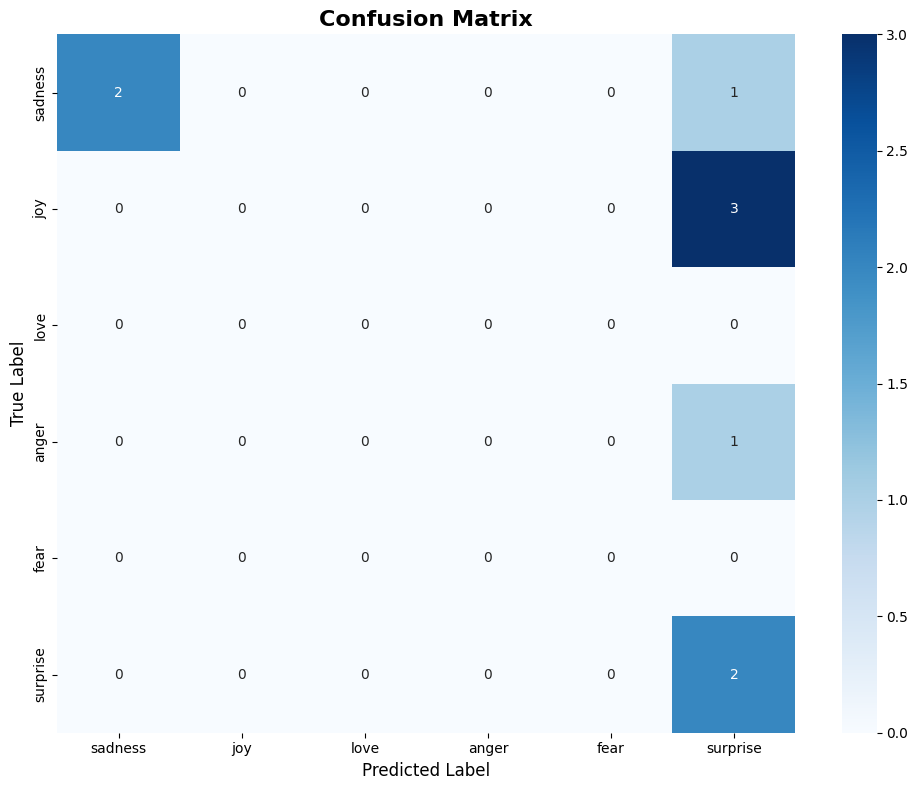

In [ ]:
def plot_confusion_matrix(cm, emotion_list):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_list, yticklabels=emotion_list)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(results['confusion_matrix'], emotion_list)